In [2]:
import lightning as L
from model import BaseLineUnet
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from dataset import GoProDataset
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import random

In [3]:
model = BaseLineUnet()
checkpoint = torch.load("lightning_logs/version_4/checkpoints/epoch=75-step=10032.ckpt")

C:\Users\minhh\AppData\Local\Temp\ipykernel_14140\1608179686.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("lightning_logs/version_4/checkpoint

In [4]:
model_weights = checkpoint["state_dict"]
for key in list(model_weights):
    model_weights[key.replace("model.", "")] = model_weights.pop(key)

In [5]:
model.load_state_dict(model_weights)
model.eval()

BaseLineUnet(
  (encoders): ModuleList(
    (0): Sequential(
      (0): BaseLineBlock(
        (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (gelu): GELU(approximate='none')
        (CA): ChannelAttention(
          (squeeze): ModuleList(
            (0): AdaptiveAvgPool2d(output_size=1)
            (1): AdaptiveMaxPool2d(output_size=1)
          )
          (excitation): Sequential(
            (0): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
            (1): ReLU()
            (2): Conv2d(2, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (sigmoid): Sigmoid()
        )
        (conv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (norm2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv4): Conv2d(32, 3

In [6]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])
dataset = GoProDataset(transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-471.7391..499.99368].


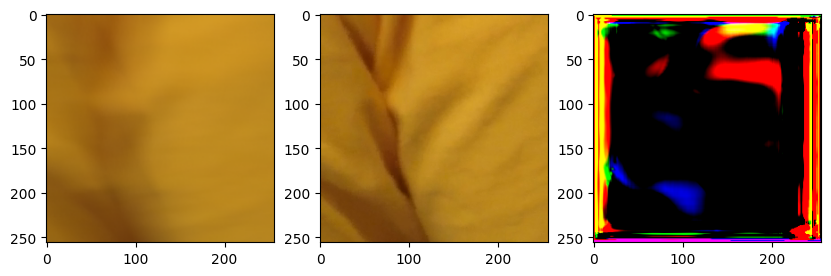

In [7]:
sample = dataset[random.randint(0, len(dataset))]
with torch.inference_mode():
    predict = model(sample[0].unsqueeze(0))

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(sample[0].numpy().transpose(1, 2, 0))
axes[1].imshow(sample[1].numpy().transpose(1, 2, 0))
axes[2].imshow(predict.squeeze().numpy().transpose(1, 2, 0))
plt.show()